In [1]:
#Installing required libraries
!pip install geopandas folium geodatasets shapely statsmodels --quiet

#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Navigating to the project folder
import os
os.chdir("/content/drive/MyDrive/terrorism_project/")


Mounted at /content/drive


In [2]:
#Checking that the file is present
!ls

region_02.csv


In [3]:
#Verifying that geopandas and folium are imported correctly
import geopandas as gpd
import folium
print("Libraries ready and working!")

Libraries ready and working!


##Step1: Data Preparation

In [4]:
#Data preparation

#More imports
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

#Loading the dataset
df=pd.read_csv("region_02.csv", low_memory=False)

#Keeping only the columns we need
keep_cols=[
    "eventid","iyear","imonth","iday",
    "country_txt","region_txt","city",
    "latitude","longitude",
    "attacktype1_txt","nkill","nwound"
]
df=df[keep_cols].copy()

#Making numeric columns to numeric
#errors="coerce" turns bad strings into NaN
num_cols=["iyear","imonth","iday","latitude","longitude","nkill","nwound"]
for c in num_cols:
    df[c]=pd.to_numeric(df[c], errors="coerce")

#Cleaning rows with missing or invalid coordinates
#dropping rows with NaN lat/lon
before=len(df)
df=df.dropna(subset=["latitude","longitude"])
after=len(df)
print(f"Rows removed due to missing coordinates: {before - after}")

Rows removed due to missing coordinates: 1000


In [5]:


#Creating a GeoDataFrame
geometry=gpd.points_from_xy(df["longitude"], df["latitude"], crs="EPSG:4326")
gdf=gpd.GeoDataFrame(df, geometry=geometry)

#Displaying the first few rows
print("\n--- First 5 rows of GeoDataFrame ---")
display(gdf.head())


--- First 5 rows of GeoDataFrame ---


,eventid,iyear,imonth,iday,country_txt,region_txt,city,latitude,longitude,attacktype1_txt,nkill,nwound,geometry
0,197000000001,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1.0,0.0,POINT (-69.95116 18.45679)
1,197001200001,1970,1,20,Guatemala,Central America & Caribbean,Guatemala City,14.622869,-90.529068,Assassination,1.0,0.0,POINT (-90.52907 14.62287)
2,197003060001,1970,3,6,Guatemala,Central America & Caribbean,Guatemala City,14.622869,-90.529068,Hostage Taking (Kidnapping),0.0,0.0,POINT (-90.52907 14.62287)
3,197003240002,1970,3,24,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Hostage Taking (Kidnapping),0.0,0.0,POINT (-69.95116 18.45679)
4,197003310001,1970,3,31,Guatemala,Central America & Caribbean,Guatemala City,14.622869,-90.529068,Hostage Taking (Kidnapping),1.0,0.0,POINT (-90.52907 14.62287)


In [9]:
#Summary statistics of numerical columns
print("\n--- Summary statistics (numeric) ---")
display(gdf[num_cols].describe())


--- Summary statistics (numeric) ---


,iyear,imonth,iday,latitude,longitude,nkill,nwound
count,9386.000000,9386.000000,9386.000000,9386.000000,9386.000000,7326.000000,7206.000000
mean,1985.021202,6.479864,14.967292,13.956899,-87.666628,3.365684,1.135165
std,5.687275,3.467924,8.504591,1.524714,4.505945,10.776091,4.461857
min,1970.000000,0.000000,0.000000,7.520050,-92.148930,0.000000,0.000000
25%,1981.000000,3.000000,8.000000,13.533333,-89.340000,0.000000,0.000000
50%,1984.000000,7.000000,15.000000,13.716667,-88.985462,0.000000,0.000000
75%,1988.000000,10.000000,22.000000,14.525764,-87.216700,2.000000,0.000000
max,2020.000000,12.000000,31.000000,25.060000,-59.493008,300.000000,130.000000


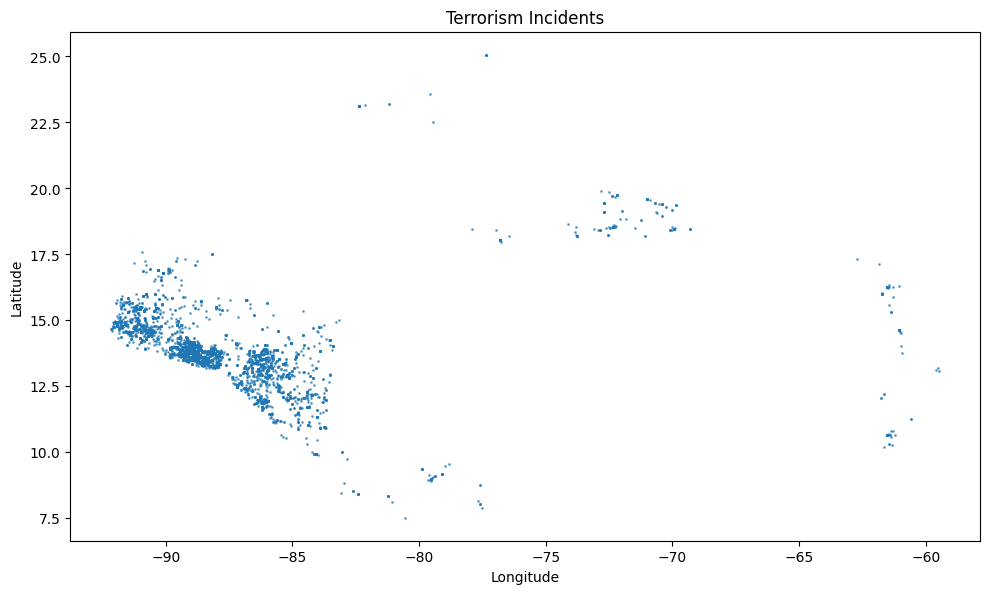

In [11]:
#Simple plot (quick check of point locations
ax = gdf.plot(figsize=(10, 6), markersize=1, alpha=0.6)
ax.set_title("Terrorism Incidents")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

##Step2 : Geospatial Visualization

###2a: Folium base map with markers

In [12]:
import folium
from folium.plugins import MarkerCluster

#Centering the map around the median latitude/longitude
center_lat=float(gdf["latitude"].median())
center_lon=float(gdf["longitude"].median())

m_markers=folium.Map(location=[center_lat, center_lon], zoom_start=3, tiles="CartoDB positron")

#Using a cluster so performance is okay even for many points
cluster=MarkerCluster().add_to(m_markers)

#Building popups: year, city, attack type, killed/wounded
def popup_text(row):
    return (
        f"<b>Year:</b> {row.get('iyear', 'NA')}<br>"
        f"<b>Country:</b> {row.get('country_txt', 'NA')}<br>"
        f"<b>City:</b> {row.get('city', 'NA')}<br>"
        f"<b>Attack type:</b> {row.get('attacktype1_txt', 'NA')}<br>"
        f"<b>Killed:</b> {row.get('nkill', 'NA')}, "
        f"<b>Wounded:</b> {row.get('nwound', 'NA')}"
    )

#Adding markers
#Because the dataset is relatively large and performance may suffer
for _, r in gdf.iterrows():
    folium.CircleMarker(
        location=[r["latitude"], r["longitude"]],
        radius=3,
        weight=0.5,
        fill=True,
        fill_opacity=0.7,
        popup=folium.Popup(popup_text(r), max_width=300)
    ).add_to(cluster)

m_markers.save("map_incidents_markers.html")
print("Saved: map_incidents_markers.html")


Saved: map_incidents_markers.html


###2b: Choropleth: Incidents per country

In [23]:
from folium.features import GeoJson, GeoJsonTooltip

#Aggregating incidents per country
country_counts=(
    gdf.groupby("country_txt")
      .size()
      .reset_index(name="incidents")
)

#Loading Natural Earth world polygons directly from the official URL (GeoPandas ≥1.0 fix)
world_url="https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)

#Keeping name + geometry only (rename English name column)
world=world.rename(columns={"NAME_EN": "name"})[["name", "geometry"]].copy()

#Basic harmonization for common mismatches between dataset and shapefile
name_fix={
    "United States": "United States of America",
    "Russia": "Russian Federation",
    "Congo (Kinshasa)": "Democratic Republic of the Congo",
    "Congo (Brazzaville)": "Republic of the Congo",
    "Ivory Coast": "Côte d'Ivoire",
    "South Korea": "Republic of Korea",
    "North Korea": "Dem. Rep. Korea",
    "Syria": "Syrian Arab Republic",
    "Vietnam": "Viet Nam",
    "Laos": "Lao PDR",
    "Tanzania": "United Republic of Tanzania",
    "Iran": "Iran",
    "Moldova": "Moldova",
}

cc=country_counts.copy()
cc["country_merge"]=cc["country_txt"].replace(name_fix).str.strip()
world["name_merge"]=world["name"].str.strip()

#Merge the counts onto the world polygons
world_counts=world.merge(cc, left_on="name_merge", right_on="country_merge", how="left")
world_counts["incidents"]=world_counts["incidents"].fillna(0).astype(int)

#Build Folium choropleth map
m_choro=folium.Map(location=[0, 0], zoom_start=2, tiles="CartoDB positron")

folium.Choropleth(
    geo_data=world_counts.to_json(),
    name="Incidents per Country",
    data=world_counts,
    columns=["name", "incidents"],
    key_on="feature.properties.name",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.2,
    nan_fill_opacity=0.1,
    legend_name="Number of Terrorism Incidents",
).add_to(m_choro)

#Tooltip: showing country and incidents when hovering
tooltip=GeoJsonTooltip(
    fields=["name", "incidents"],
    aliases=["Country", "Incidents"],
    localize=True,
    sticky=False,
)
GeoJson(
    data=world_counts.to_json(),
    name="Labels",
    tooltip=tooltip,
    style_function=lambda x: {"fillOpacity": 0, "color": "transparent"},
).add_to(m_choro)

folium.LayerControl().add_to(m_choro)

#Save HTML map
m_choro.save("map_choropleth_incidents.html")
print("Saved: map_choropleth_incidents.html")

#quick unmatched check
unmatched = world_counts[world_counts["incidents"] == 0][["name"]]
print(f"Countries with 0 incidents: {len(unmatched)}")
display(unmatched.head(20))


Saved: map_choropleth_incidents.html
Countries with 0 incidents: 165


,name
0,Fiji
1,Tanzania
2,Western Sahara
3,Canada
4,United States of America
5,Kazakhstan
6,Uzbekistan
7,Papua New Guinea
8,Indonesia
9,Argentina


In [16]:
import numpy as np
from folium.features import GeoJson, GeoJsonTooltip
import branca.colormap as cm

#Choosing to color by log scale instead of raw counts because only the few countries dominate
USE_LOG_SCALE = True

#Preparing values for scaling
vals = world_counts["incidents"].astype(float).fillna(0.0)
if USE_LOG_SCALE:
    vals_to_color = np.log1p(vals)  #log(1+x) keeps 0 -> 0
    vmin, vmax = float(vals_to_color.min()), float(vals_to_color.max())
else:
    vals_to_color = vals
    vmin, vmax = float(vals.min()), float(vals.max())

#Attaching the value to properties for styling
world_counts = world_counts.copy()
world_counts["val_for_color"] = vals_to_color

#Building a continuous colormap
cmap = cm.linear.YlOrRd_09.scale(vmin, vmax)
cmap.caption = "Incidents (continuous intensity{})".format(" – log scale" if USE_LOG_SCALE else "")

#Base map
m_cont = folium.Map(location=[0, 0], zoom_start=2, tiles="CartoDB positron")

#Style function pulls the transformed value to pick a color continuously
def style_fn(feature):
    val=feature["properties"].get("val_for_color", 0.0)
    #Guarding against None
    val = 0.0 if val is None or np.isnan(val) else float(val)
    return {
        "fillColor": cmap(val),
        "color": "white",       # country borders
        "weight": 0.3,
        "fillOpacity": 0.85,
    }

#Tooltip shows the TRUE incident count (not the log)
tooltip = GeoJsonTooltip(
    fields=["name", "incidents"],
    aliases=["Country", "Incidents"],
    localize=True,
    sticky=False,
)

gj=GeoJson(
    data=world_counts.to_json(),
    name="Incidents (continuous)",
    style_function=style_fn,
    tooltip=tooltip,
)
gj.add_to(m_cont)
cmap.add_to(m_cont)
folium.LayerControl().add_to(m_cont)

m_cont.save("map_choropleth_incidents_continuous.html")
print("Saved: map_choropleth_incidents_continuous.html")
print(f"Color scale range: [{vmin:.3f}, {vmax:.3f}]  ({'log1p' if USE_LOG_SCALE else 'raw'} values)")

Saved: map_choropleth_incidents_continuous.html
Color scale range: [0.000, 8.486]  (log1p values)


In [15]:
sorted(df["country_txt"].dropna().unique())

['Antigua and Barbuda',
 'Bahamas',
 'Barbados',
 'Belize',
 'Costa Rica',
 'Cuba',
 'Dominica',
 'Dominican Republic',
 'El Salvador',
 'Grenada',
 'Guadeloupe',
 'Guatemala',
 'Haiti',
 'Honduras',
 'Jamaica',
 'Martinique',
 'Nicaragua',
 'Panama',
 'St. Kitts and Nevis',
 'St. Lucia',
 'Trinidad and Tobago']

###2c: Heatmap

In [22]:
from folium.plugins import HeatMap

#Recomputing sensible map center (median of valid points)
center_lat=float(gdf["latitude"].median())
center_lon=float(gdf["longitude"].median())

#Base map (using dark tiles to make heatmaps pop)
m_heat=folium.Map(location=[center_lat, center_lon], zoom_start=3, tiles="CartoDB dark_matter")

#Option A: equal weight per incident
heat_data = gdf[["latitude", "longitude"]].dropna().values.tolist()

#Option B: weight by severity (killed + wounded)
#sev=(gdf[["nkill","nwound"]].fillna(0).sum(axis=1)).clip(lower=0)
#heat_data = np.column_stack([gdf["latitude"], gdf["longitude"], sev]).tolist()

HeatMap(
    data=heat_data,
    radius=8,        #larger radius=smoother blobs
    blur=12,         #how much to blur
    min_opacity=0.2, #keeping low-density areas visible
    max_zoom=6,      #tuning for performance/appearance
    gradient={0.0:'black', 0.3:'purple', 0.6:'orange', 1.0:'yellow'}
).add_to(m_heat)

m_heat.save("map_heatmap_incidents.html")
print("Saved: map_heatmap_incidents.html")


Saved: map_heatmap_incidents.html


##Step3: Attack Type Analysis

In [25]:
import matplotlib.pyplot as plt
from textwrap import wrap

#Cleaning the attack type column (standardize text, handle nulls)
col="attacktype1_txt"
gdf[col]=gdf[col].astype(str).str.strip()
gdf[col]=gdf[col].replace({"nan": np.nan, "": np.nan})
gdf[col]=gdf[col].fillna("Unknown")

In [26]:
#Frequency table (counts and percentages)
freq=(
    gdf[col]
    .value_counts(dropna=False)
    .rename_axis("attack_type")
    .reset_index(name="count")
)
freq["percent"]=(freq["count"] / freq["count"].sum() * 100).round(2)

###3a: Frequency

In [27]:
#Saving a clean CSV for submission
freq.to_csv("attack_type_frequency.csv", index=False)
print("Saved: attack_type_frequency.csv")
display(freq.head(10))

Saved: attack_type_frequency.csv


,attack_type,count,percent
0,Armed Assault,3842,40.93
1,Bombing/Explosion,2912,31.02
2,Assassination,1232,13.13
3,Hostage Taking (Kidnapping),475,5.06
4,Facility/Infrastructure Attack,390,4.16
5,Unknown,310,3.30
6,Hostage Taking (Barricade Incident),181,1.93
7,Hijacking,25,0.27
8,Unarmed Assault,19,0.20


###3b: Pie charts

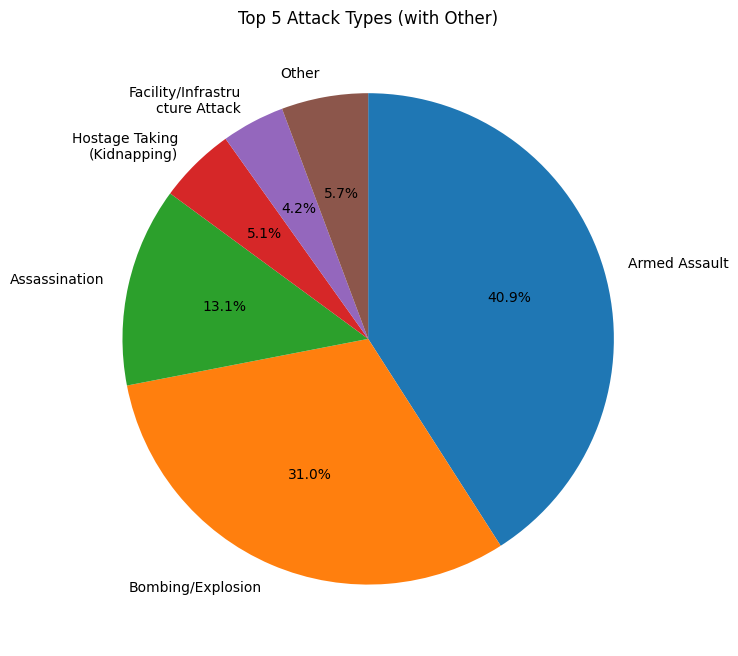

Saved: attack_types_top5_pie.png


In [29]:
#Top 5 attack types
top5=freq.head(5).copy()
top5_labels=top5["attack_type"].tolist()
top5_counts=top5["count"].tolist()

#Computing "Other" bucket for the pie
other_count=freq["count"].iloc[5:].sum()
if other_count>0:
    pie_labels=top5_labels+["Other"]
    pie_counts=top5_counts+[other_count]
else:
    pie_labels=top5_labels
    pie_counts=top5_counts

#PIE chart
plt.figure(figsize=(7.5, 7.5))
#Wrapping long labels to avoid overflow
wrapped_labels=["\n".join(wrap(lbl, width=18)) for lbl in pie_labels]
plt.pie(
    pie_counts,
    labels=wrapped_labels,
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False
)
plt.title("Top 5 Attack Types (with Other)")
plt.tight_layout()
plt.savefig("attack_types_top5_pie.png", dpi=200)
plt.show()
print("Saved: attack_types_top5_pie.png")

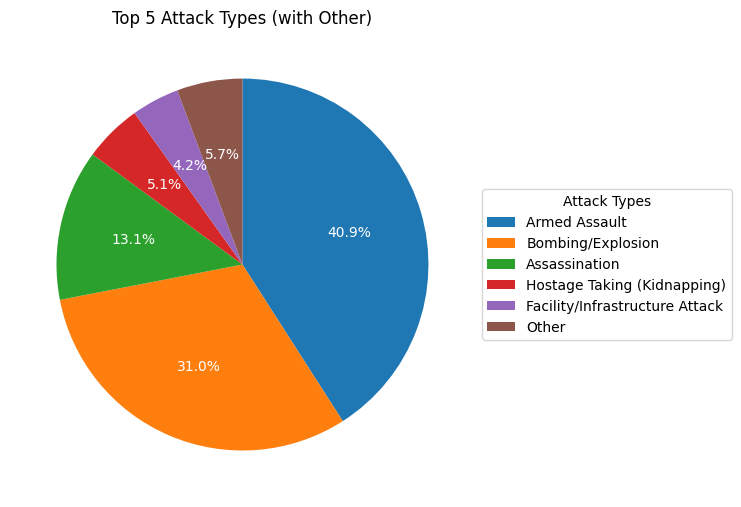

Saved: attack_types_top5_pie_legend.png


In [30]:
#Piechart with legend
plt.figure(figsize=(7.5, 7.5))

#Plot without labels on slices
patches, texts, autotexts=plt.pie(
    pie_counts,
    startangle=90,
    counterclock=False,
    autopct="%1.1f%%",
    textprops={'color':"white"},  #white text inside slices (for contrast)
)

#Adding legend to the side
plt.legend(
    patches,                #slice handles
    pie_labels,             #attack type names
    title="Attack Types",
    loc="center left",
    bbox_to_anchor=(1, 0.5),  # position legend outside the pie
    fontsize=10
)

plt.title("Top 5 Attack Types (with Other)")
plt.tight_layout()
plt.savefig("attack_types_top5_pie_legend.png", dpi=200, bbox_inches="tight")
plt.show()
print("Saved: attack_types_top5_pie_legend.png")


###3c: Bar charts

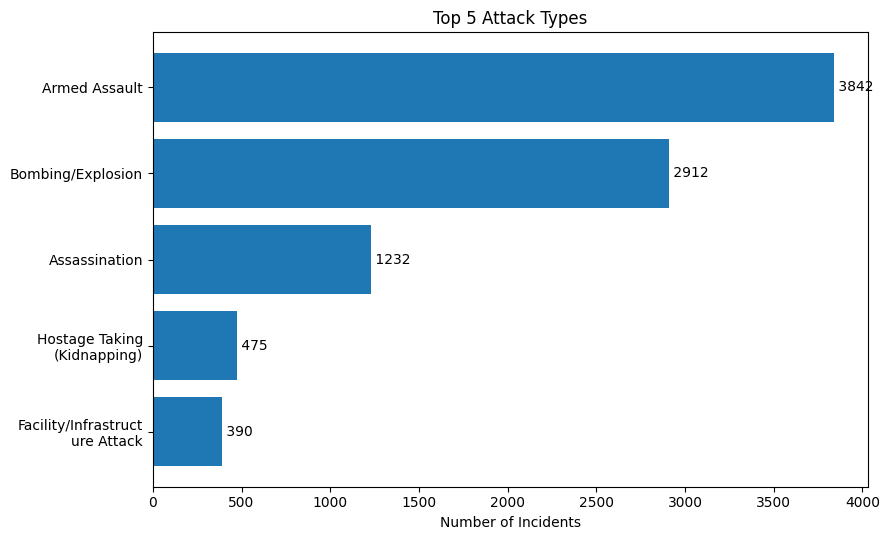

Saved: attack_types_top5_bar.png


In [31]:
#Top 5 bar chart
plt.figure(figsize=(9, 5.5))
y=[ "\n".join(wrap(x, width=20)) for x in top5["attack_type"] ]
plt.barh(y, top5["count"])
plt.gca().invert_yaxis()
plt.xlabel("Number of Incidents")
plt.title("Top 5 Attack Types")
# Annotate bars with values
for i, v in enumerate(top5["count"]):
    plt.text(v, i, f" {v}", va="center")
plt.tight_layout()
plt.savefig("attack_types_top5_bar.png", dpi=200)
plt.show()
print("Saved: attack_types_top5_bar.png")

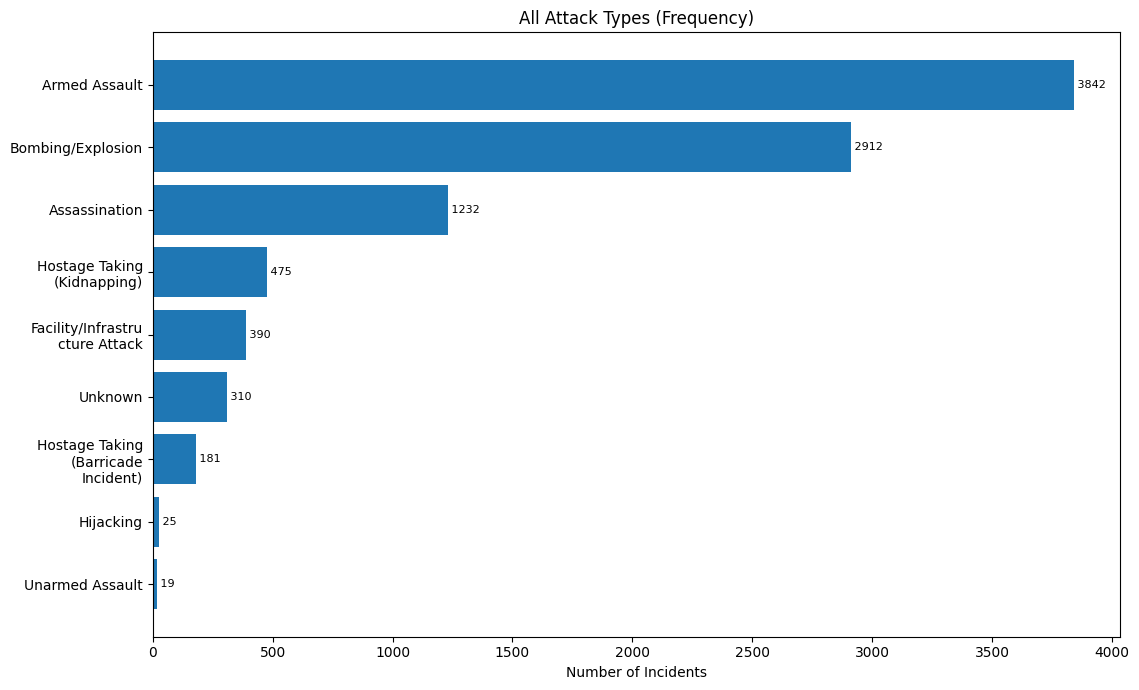

Saved: attack_types_all_bar.png


In [32]:
#Full distribution bar chart
plt.figure(figsize=(11.5, 7))
full_y=[ "\n".join(wrap(x, width=18)) for x in freq["attack_type"] ]
plt.barh(full_y, freq["count"])
plt.gca().invert_yaxis()
plt.xlabel("Number of Incidents")
plt.title("All Attack Types (Frequency)")
#small text labels for clarity
for i, v in enumerate(freq["count"]):
    plt.text(v, i, f" {v}", va="center", fontsize=8)
plt.tight_layout()
plt.savefig("attack_types_all_bar.png", dpi=200)
plt.show()
print("Saved: attack_types_all_bar.png")

##Step 4: Time Series Analysis

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Aggregating incidents by year
yearly_incidents=gdf.groupby("iyear").size().reset_index(name="incident_count")

#Converting to datetime index (required for decomposition)
ts=yearly_incidents.set_index("iyear")
ts.index=pd.to_datetime(ts.index, format="%Y")

###4a: Line plot

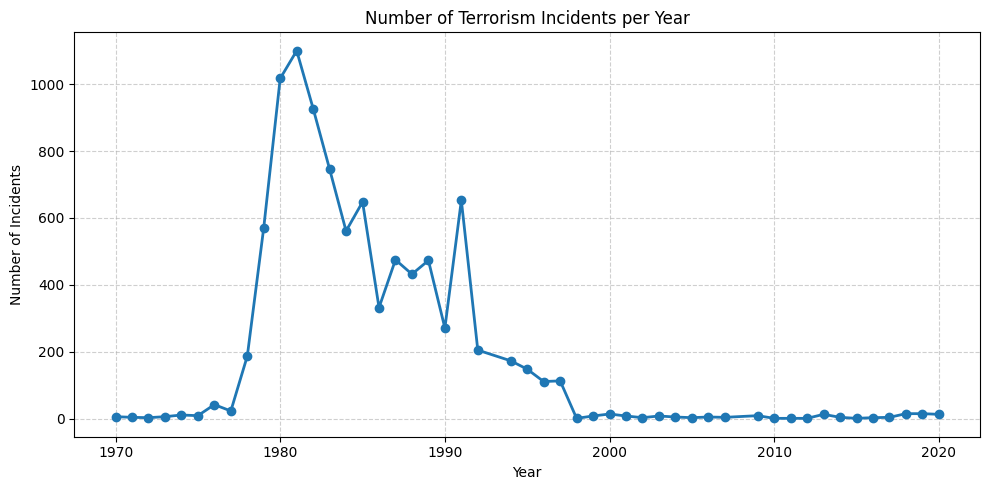

Saved: incidents_per_year_line.png


In [34]:
#Line plot of incidents per year
plt.figure(figsize=(10,5))
plt.plot(ts.index, ts["incident_count"], marker="o", linewidth=2)
plt.title("Number of Terrorism Incidents per Year")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("incidents_per_year_line.png", dpi=200)
plt.show()
print("Saved: incidents_per_year_line.png")

###4b: Time series decomposition

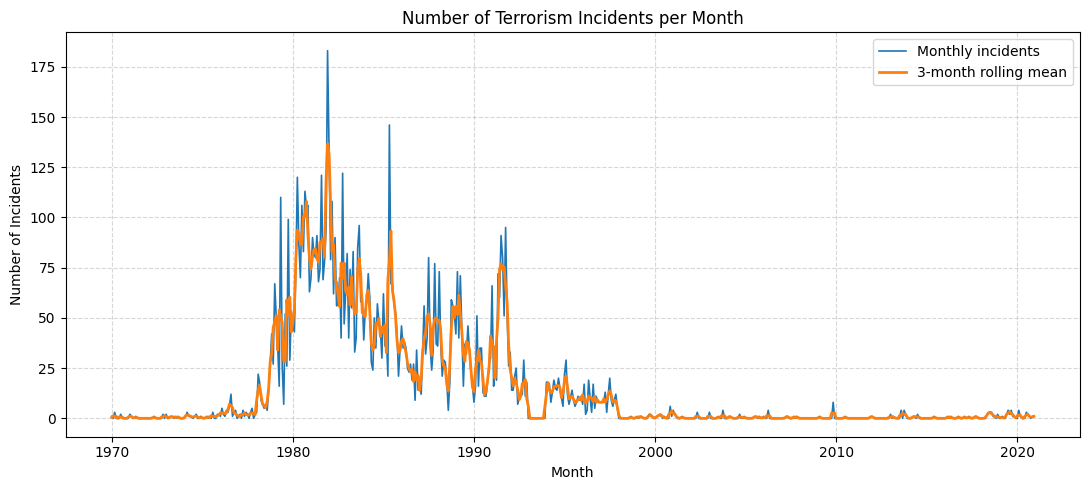

Saved: incidents_per_month_line.png


In [36]:
#Monthly decomposition
#Keeping only rows with a valid month (1-12)
#imonth=0 means unknown month
df_monthly=gdf[(gdf["imonth"] >= 1) & (gdf["imonth"] <= 12)].copy()

#Building a monthly date (day=1)
df_monthly["date"]=pd.to_datetime(
    dict(year=df_monthly["iyear"].astype(int), month=df_monthly["imonth"].astype(int), day=1),
    errors="coerce"
)

#Aggregating to counts per month
monthly_counts=(
    df_monthly.groupby("date")
    .size()
    .rename("incident_count")
    .to_frame()
    .sort_index()
)

#Reindexing to a complete monthly range so there are no gaps/NaNs
full_idx=pd.date_range(monthly_counts.index.min(), monthly_counts.index.max(), freq="MS")  # Month Start
ts_month=monthly_counts.reindex(full_idx).fillna(0)

#smoothing a little for the line plot
ts_month["rolling_3mo"] = ts_month["incident_count"].rolling(window=3, center=True, min_periods=1).mean()

#Monthly line plot
plt.figure(figsize=(11,5))
plt.plot(ts_month.index, ts_month["incident_count"], linewidth=1.2, label="Monthly incidents")
plt.plot(ts_month.index, ts_month["rolling_3mo"], linewidth=2.0, label="3-month rolling mean")
plt.title("Number of Terrorism Incidents per Month")
plt.xlabel("Month")
plt.ylabel("Number of Incidents")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("incidents_per_month_line.png", dpi=200)
plt.show()
print("Saved: incidents_per_month_line.png")

In [37]:
#Decomposition on monthly data (period=12 for yearly seasonality)
#Ensuring float and no missing values
series=ts_month["incident_count"].astype(float)

#statsmodels requires period >= 2; monthly → 12 makes sense
decomp=seasonal_decompose(series, model="additive", period=12)

###4c: Plotting decomposition

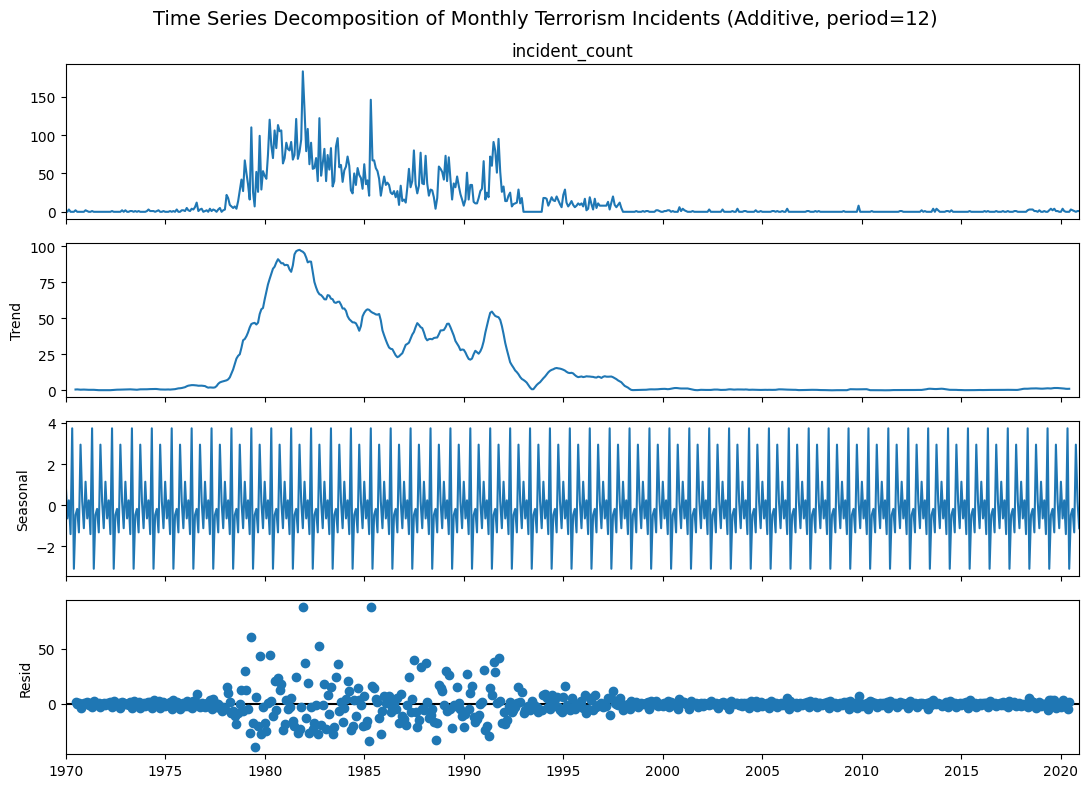

Saved: time_series_decomposition_monthly.png


In [38]:
#Plotting decomposition
fig = decomp.plot()
fig.set_size_inches(11, 8)
fig.suptitle("Time Series Decomposition of Monthly Terrorism Incidents (Additive, period=12)", fontsize=14)
plt.tight_layout()
plt.savefig("time_series_decomposition_monthly.png", dpi=200)
plt.show()
print("Saved: time_series_decomposition_monthly.png")

###4d: Interpretation

The time series decomposition of monthly terrorism incidents revealed a strong upward trend from the mid- 1970s to the mid 1980s. Then it gradually declined and finally became stable after 2000s. The seasonal one shows a pattern which means there are certain months which get more terrorism incidents.